<a href="https://colab.research.google.com/github/jarvis2991/pytorch/blob/main/Deep_Neural_Network_on_GPU_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
%matplotlib inline


In [2]:
dataset = MNIST(root='data/', download=True, transform = transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Image shape : torch.Size([1, 28, 28])
Label : 5


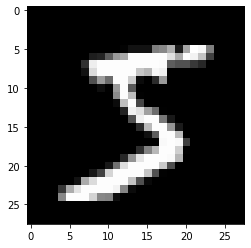

In [3]:
image, label = dataset[0]
print('Image shape :',image.shape)
print('Label :',label)
plt.imshow(image[0], cmap='gray')

In [4]:
val_split = 0.20
val_size = int(val_split * len(dataset))

train_size = len(dataset) - val_size

train_ds, val_ds, = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(48000, 12000)

In [5]:
batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle = True)
val_dl = DataLoader(val_ds, batch_size)

torch.Size([128, 1, 28, 28])
torch.Size([128])


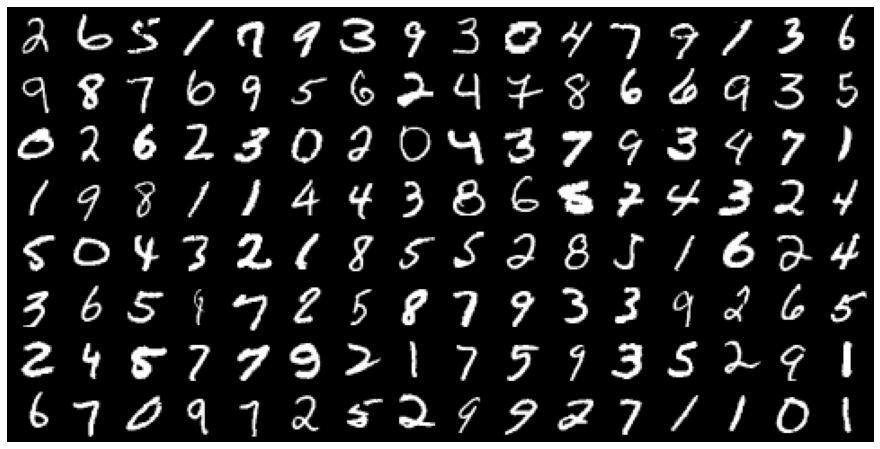

In [6]:
for xb, yb in train_dl:
  print(xb.shape)
  print(yb.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  #a = make_grid(xb,nrow=16)
  #print(a.shape)
  plt.imshow(make_grid(xb,nrow=16).permute(1,2,0))
  break

In [7]:
for xb, yb in train_dl:
  print(xb.shape)
  x = xb.view(xb.size(0),-1)
  print(x.shape)
  break

torch.Size([128, 1, 28, 28])
torch.Size([128, 784])


In [8]:
class MnistModel(nn.Module):
  def __init__(self, in_size, hidden_size, out_size):
    super().__init__()
    self.linear1 = nn.Linear(in_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, out_size)

  def forward(self, xb):
    xb = xb.view(xb.size(0),-1)

    out = self.linear1(xb)

    out = F.relu(out)

    out = self.linear2(out)
    return out

In [9]:
input_size = 784
num_classes = 10

model = MnistModel(input_size, hidden_size = 32, out_size = num_classes)

In [10]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [11]:
for images, labels in train_dl:
  print(images.shape)
  outputs = model(images)
  loss = F.cross_entropy(outputs, labels)
  print('Loss: ', loss.item())
  break

torch.Size([128, 1, 28, 28])
Loss:  2.306809902191162


In [31]:
print(torch.cuda.device_count())

1


In [13]:
torch.cuda.is_available()

True

In [14]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking = True)

In [17]:
for images, labels in train_dl:
  print(images.shape)
  print(images.device)
  images = to_device(images, device)
  print(images.device)
  break

torch.Size([128, 1, 28, 28])
cpu
cuda:0


In [32]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [23]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)

In [30]:
for xb, yb in valid_dl:
  print(xb.device)
  print(yb)
  break
  #a = 1

cuda:0
tensor([3, 6, 6, 7, 7, 5, 6, 3, 1, 7, 0, 8, 5, 6, 2, 3, 2, 1, 0, 3, 6, 0, 7, 9,
        3, 4, 0, 9, 6, 0, 5, 8, 1, 8, 1, 2, 6, 8, 7, 1, 2, 5, 3, 1, 9, 0, 7, 8,
        6, 2, 9, 0, 3, 4, 0, 2, 1, 1, 1, 4, 4, 1, 6, 1, 8, 6, 6, 5, 1, 8, 4, 4,
        2, 1, 9, 3, 4, 6, 2, 3, 9, 6, 0, 9, 3, 0, 9, 6, 1, 8, 3, 8, 7, 9, 1, 9,
        2, 9, 7, 8, 7, 3, 8, 1, 6, 4, 2, 6, 7, 6, 7, 2, 4, 5, 4, 1, 9, 3, 1, 4,
        4, 5, 0, 8, 6, 3, 2, 8], device='cuda:0')


# **Training the model**

We will define the model, evaluate and fit functions here.

In [48]:
 class MnistModel(nn.Module):
   def __init__(self, in_size, hidden_size, out_size):
     super().__init__()
     self.linear1 = nn.Linear(in_size, hidden_size)
     self.linear2 = nn.Linear(hidden_size, out_size)

   def forward(self, xb):
     xb = xb.view(xb.size(0),-1)
     out = self.linear1(xb)
     out = F.relu(out)
     out = self.linear2(out)
     return out

   def training_step(self, batch):
     images, labels = batch
     out = self(images)
     loss = F.cross_entropy(out, labels)
     return loss

   def validation_step(self, batch):
     images, labels = batch
     out = self(images)
     loss = F.cross_entropy(out, labels)
     acc = accuracy(out, labels)
     return {'val_loss':loss, 'val_acc':acc}    

   def validation_epoch_end(self, outputs):
     batch_losses = [x['val_loss'] for x in outputs]
     epoch_loss = torch.stack(batch_losses).mean()
     batch_acc = [x['val_acc'] for x in outputs]
     epoch_acc = torch.stack(batch_acc).mean()
     return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}   
  
   def epoch_end(self, epoch, result):
     print('Epoch {}, val_loss: {:.4f}, val_acc: {:.4f}'.format(epoch, result['val_loss'], result['val_acc']))


In [49]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [50]:
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [57]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)

  for epoch in range(epochs):
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  
  return history

In [58]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

In [59]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [60]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [61]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.04274711757898331, 'val_loss': 2.3136651515960693}]

In [62]:
history += fit(5, 0.5, model, train_dl, valid_dl)

Epoch 0, val_loss: 0.2265, val_acc: 0.9317
Epoch 1, val_loss: 0.2335, val_acc: 0.9290
Epoch 2, val_loss: 0.1599, val_acc: 0.9515
Epoch 3, val_loss: 0.1414, val_acc: 0.9594
Epoch 4, val_loss: 0.1342, val_acc: 0.9602


In [63]:
history += fit(5, 0.5, model, train_dl, valid_dl)

Epoch 0, val_loss: 0.1216, val_acc: 0.9645
Epoch 1, val_loss: 0.1273, val_acc: 0.9616
Epoch 2, val_loss: 0.1218, val_acc: 0.9650
Epoch 3, val_loss: 0.1252, val_acc: 0.9638
Epoch 4, val_loss: 0.1132, val_acc: 0.9675


Text(0.5, 1.0, 'Loss vs No. of epochs')

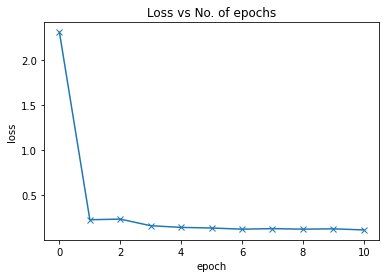

In [64]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs No. of epochs')

Text(0.5, 1.0, 'acc vs No. of epochs')

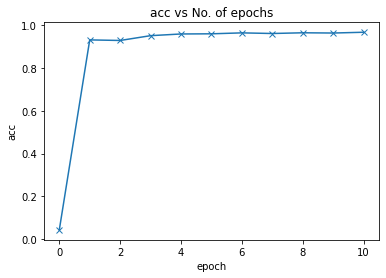

In [65]:
accs = [x['val_acc'] for x in history]
plt.plot(accs, '-x')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('acc vs No. of epochs')

# Testing with test dataset

In [66]:
test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor())

In [67]:
def predict_image(img, model):
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, pred = torch.max(yb, dim=1)
  return pred[0].item()

Label:  7 , Predicted:  7


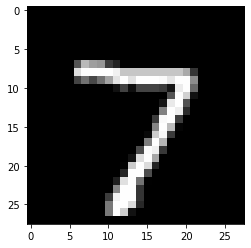

In [69]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label: ',label,', Predicted: ', predict_image(img,model))

Label:  6 , Predicted:  6


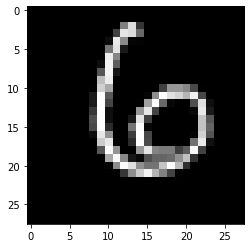

In [70]:
img, label = test_dataset[100]
plt.imshow(img[0], cmap='gray')
print('Label: ',label,', Predicted: ', predict_image(img,model))

Label:  4 , Predicted:  4


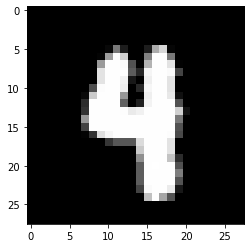

In [71]:
img, label = test_dataset[250]
plt.imshow(img[0], cmap='gray')
print('Label: ',label,', Predicted: ', predict_image(img,model))

In [72]:
test_loader = DeviceDataLoader( DataLoader(test_dataset, batch_size=2560), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.9706863164901733, 'val_loss': 0.10592021048069}